<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/posible_plan_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración inicial
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', None)

# Cargar datos
df = pd.read_csv('fallecidos-nueva-2019.csv', encoding='latin-1')

# Preprocesamiento mejorado
df['Fechayhora'] = pd.to_datetime(df['Fechayhora'])
df['Año'] = df['Fechayhora'].dt.year
df['Mes'] = df['Fechayhora'].dt.month
df['Hora'] = df['Fechayhora'].dt.hour
df['DiaSemana'] = df['Fechayhora'].dt.day_name()
df['EsFinDeSemana'] = df['DiaSemana'].isin(['Saturday', 'Sunday']).astype(int)
df['HoraCategoria'] = pd.cut(df['Hora'], bins=[0,6,12,18,24], labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'])

# Variable objetivo mejorada (fallecimiento inmediato o dentro de 24 horas)
df['Objetivo'] = np.where(df['FallecidoalosDias'] <= 1, 1, 0)

<ipython-input-14-d47705cc4877>:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



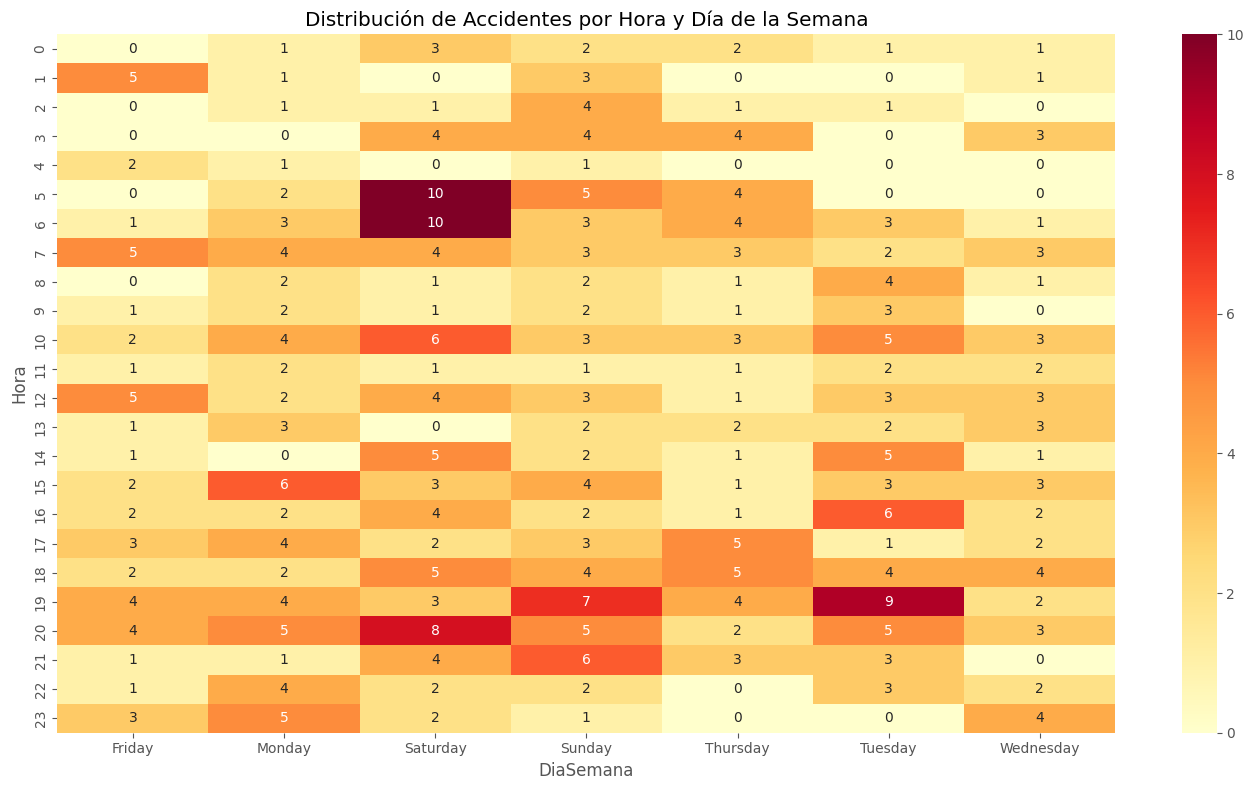

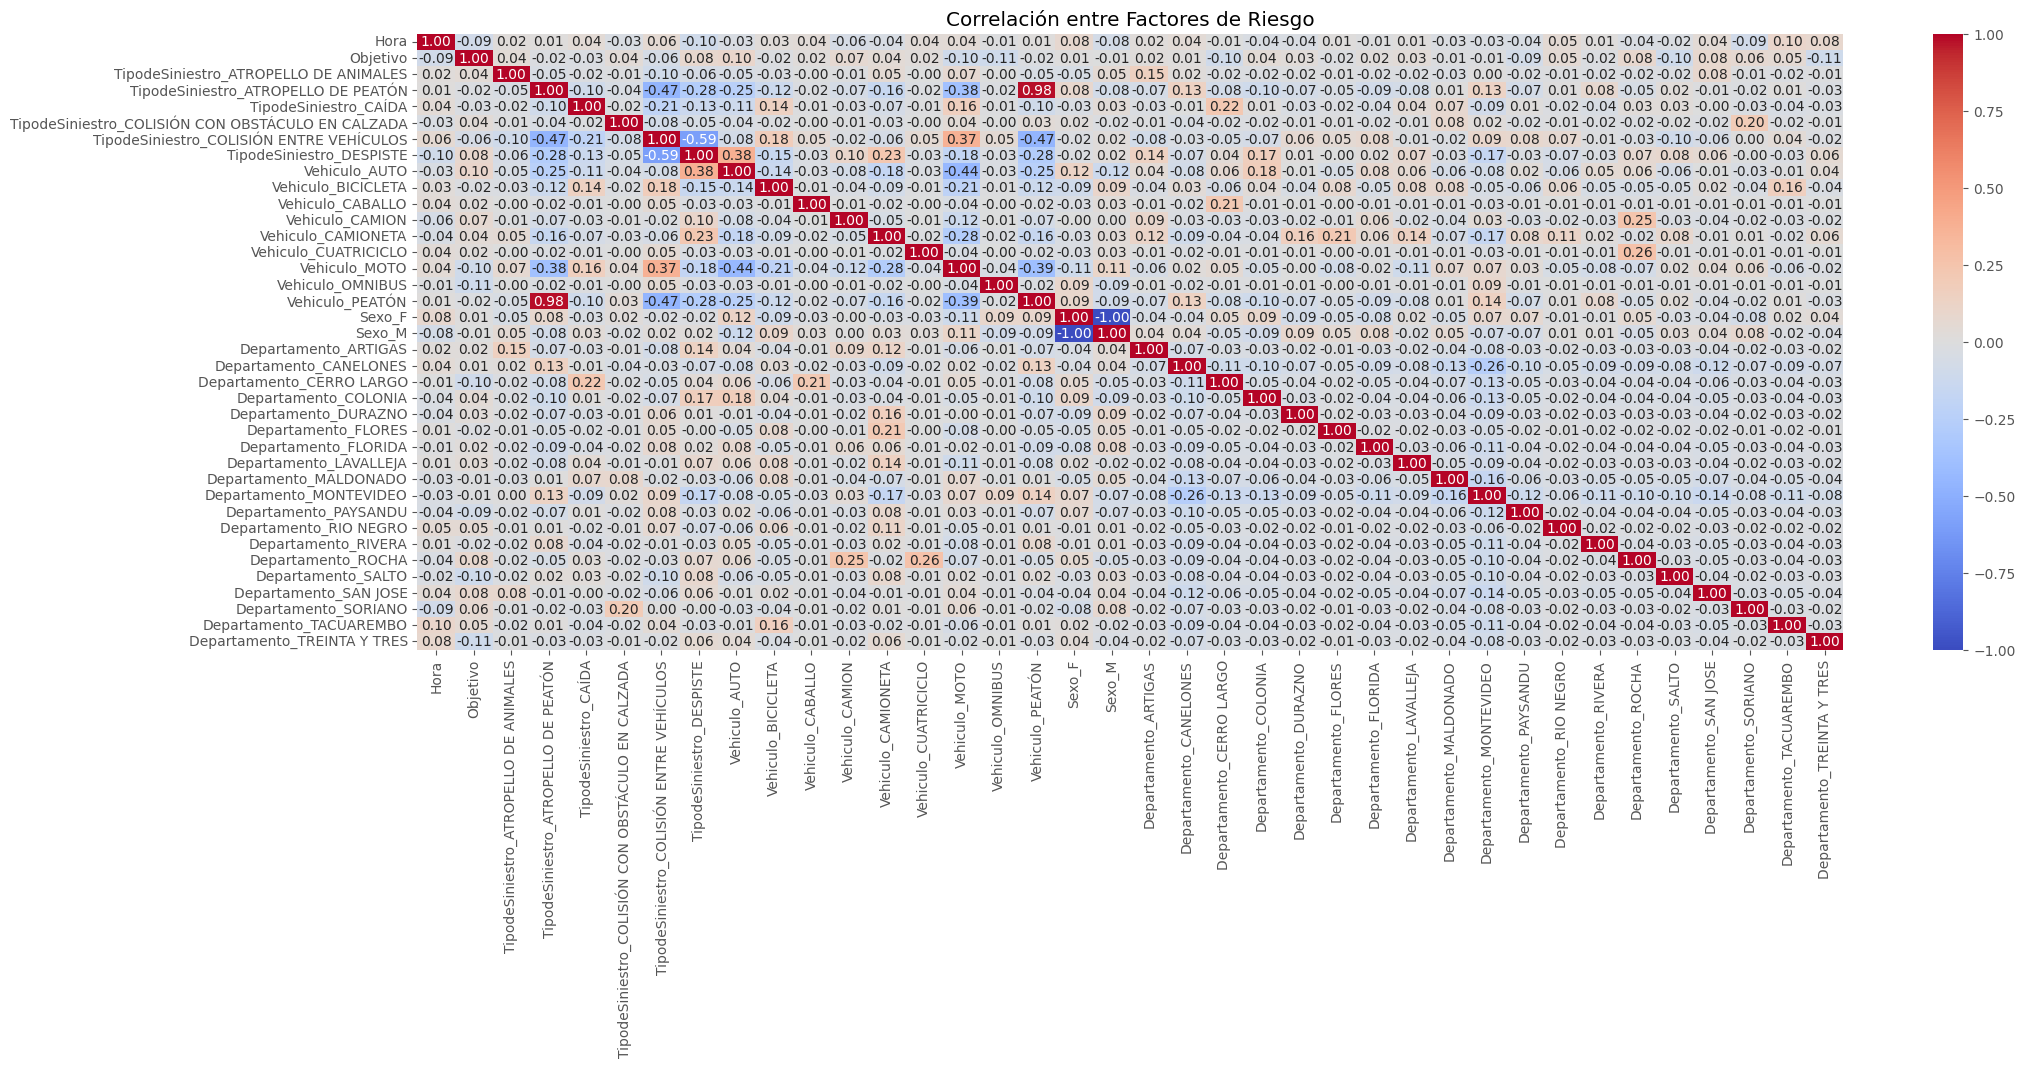

In [14]:
# =============================================
# 1. ANÁLISIS EXPLORATORIO MEJORADO
# =============================================

# Gráfico interactivo de distribución temporal
fig = px.line(df.resample('M', on='Fechayhora').size(),
              title='Tendencia Mensual de Accidentes Fatales',
              labels={'value': 'Número de fallecidos', 'Fechayhora': 'Fecha'})
fig.update_layout(hovermode="x unified")
fig.show()

# Heatmap de accidentes por hora y día
plt.figure(figsize=(14, 8))
heatmap_data = df.pivot_table(index='Hora', columns='DiaSemana',
                             values='Objetivo', aggfunc='count',
                             fill_value=0)
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt="d")
plt.title('Distribución de Accidentes por Hora y Día de la Semana')
plt.tight_layout()
plt.show()

# Gráfico de correlación de factores
plt.figure(figsize=(23, 8))
corr_matrix = df[['TipodeSiniestro', 'Vehiculo', 'Sexo', 'Departamento', 'Hora', 'Objetivo']]
corr_matrix = pd.get_dummies(corr_matrix).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('Correlación entre Factores de Riesgo')
plt.show()

In [4]:
# =============================================
# 2. MODELO ARIMA MEJORADO CON VALIDACIÓN CRUZADA
# =============================================

# Preparar datos para ARIMA con suavizado exponencial
ts_data = df.set_index('Fechayhora').resample('D').size().ewm(span=7).mean()

# División mejorada con validación cruzada temporal
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Optimización de parámetros ARIMA
best_aic = np.inf
best_order = None
for p in range(0, 5):
    for d in range(0, 2):
        for q in range(0, 5):
            try:
                model = ARIMA(train, order=(p,d,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,d,q)
            except:
                continue

print(f"Mejores parámetros ARIMA: {best_order} con AIC: {best_aic}")

# Entrenar modelo con mejores parámetros
model_arima = ARIMA(train, order=best_order)
fitted_model = model_arima.fit()

# Pronóstico con intervalos de confianza
forecast = fitted_model.get_forecast(steps=len(test))
forecast_df = forecast.conf_int()
forecast_df['Pronóstico'] = fitted_model.predict(start=forecast_df.index[0],
                                               end=forecast_df.index[-1])

# Visualización interactiva
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, name='Entrenamiento'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Real'))
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Pronóstico'], name='Pronóstico'))
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['lower y'],  # Changed column name to 'lower y'
                        fill=None, mode='lines', line_color='rgba(255,0,0,0.1)'))
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['upper y'],  # Changed column name to 'upper y'
                        fill='tonexty', mode='lines', line_color='rgba(255,0,0,0.1)'))
fig.update_layout(title='Pronóstico ARIMA con Intervalos de Confianza',
                 xaxis_title='Fecha',
                 yaxis_title='Número de Fallecidos')
fig.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sa

Mejores parámetros ARIMA: (4, 1, 3) con AIC: 21.434926583932764


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:17:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 87.94%
AUC-ROC: 90.85%

Reporte de Clasificación Mejorado:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        71
           1       0.85      0.91      0.88        70

    accuracy                           0.88       141
   macro avg       0.88      0.88      0.88       141
weighted avg       0.88      0.88      0.88       141



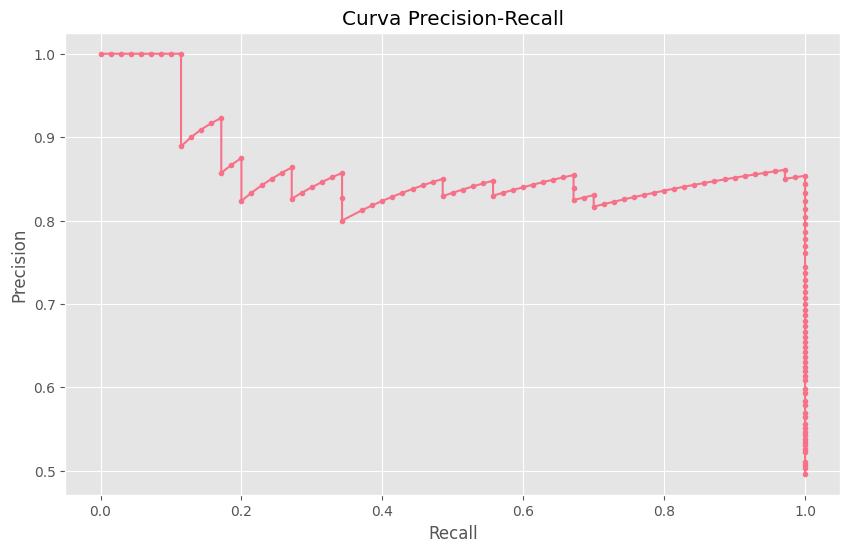

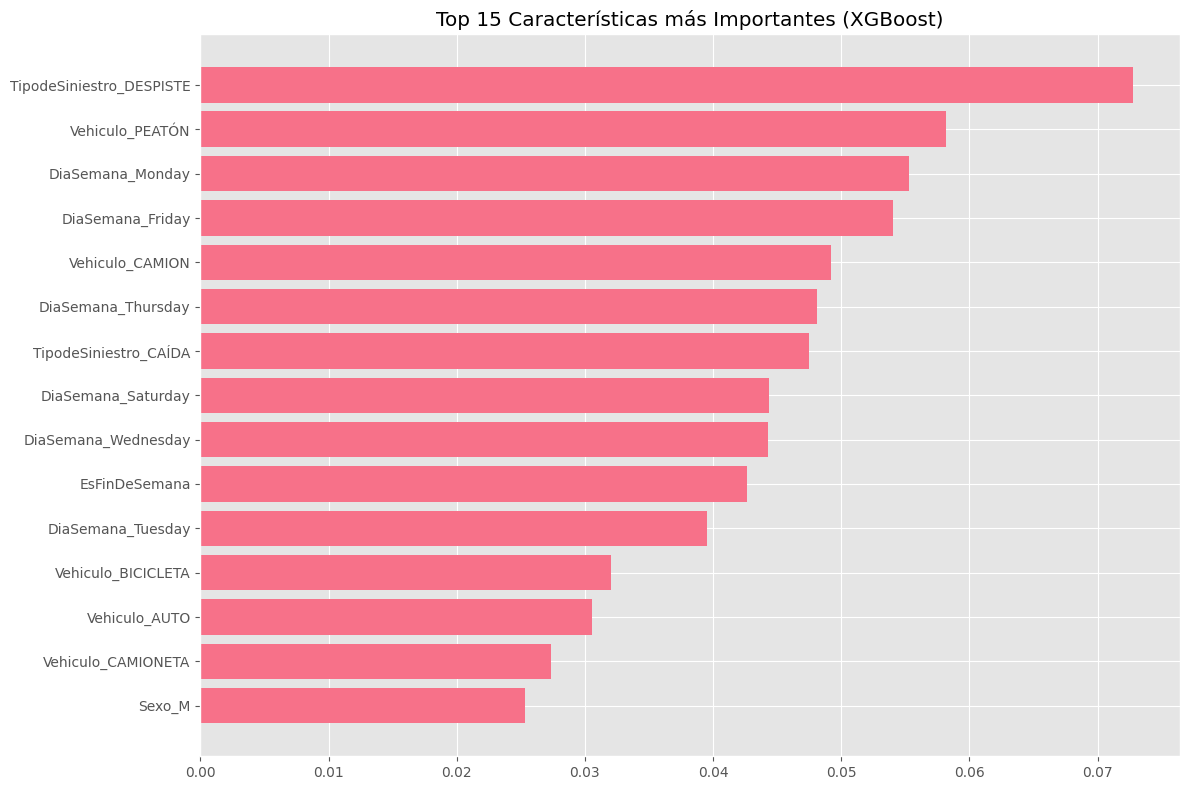

In [5]:
# =============================================
# 3. MODELO DE CLASIFICACIÓN MEJORADO (XGBoost + SMOTE)
# =============================================

# Preprocesamiento avanzado
features = ['TipodeSiniestro', 'Vehiculo', 'Sexo', 'Departamento', 'Año', 'Mes', 'Hora', 'DiaSemana', 'EsFinDeSemana', 'HoraCategoria']
X = df[features]
y = df['Objetivo']

# Codificación One-Hot para categorías
X_encoded = pd.get_dummies(X, columns=['TipodeSiniestro', 'Vehiculo', 'Sexo', 'Departamento', 'DiaSemana', 'HoraCategoria'])

# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Modelo XGBoost con búsqueda de hiperparámetros
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb, params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas avanzadas
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2%}")

# Reporte de clasificación
print("\nReporte de Clasificación Mejorado:")
print(classification_report(y_test, y_pred))

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

# Importancia de características
plt.figure(figsize=(12, 8))
sorted_idx = best_model.feature_importances_.argsort()
plt.barh(X_encoded.columns[sorted_idx][-15:], best_model.feature_importances_[sorted_idx][-15:])
plt.title('Top 15 Características más Importantes (XGBoost)')
plt.tight_layout()
plt.show()


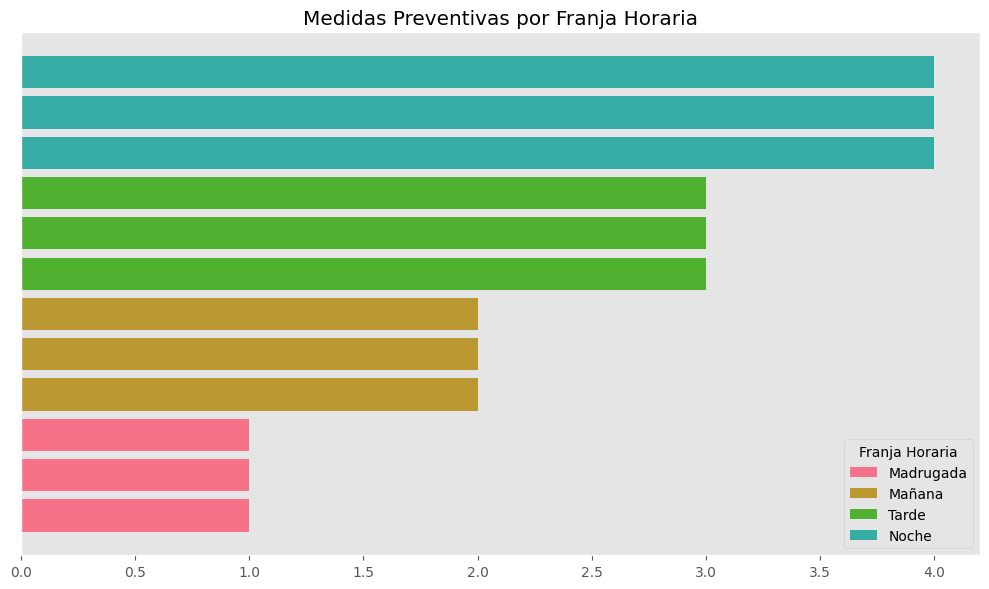

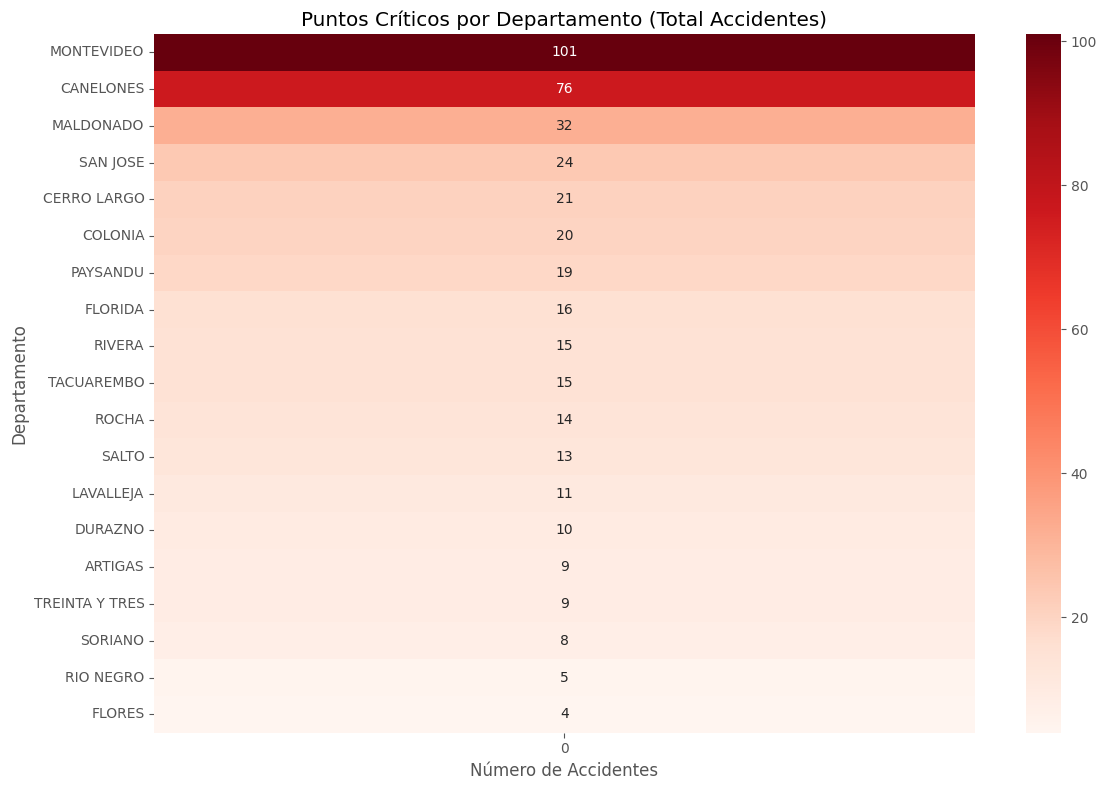

In [10]:
# =============================================
# 4. PLANES DE PREVENCIÓN BASADOS EN DATOS
# =============================================

# Gráfico de estrategias de prevención por tipo de siniestro
top_siniestros = df['TipodeSiniestro'].value_counts().nlargest(5).index
prevention_strategies = {
    'Colisión': ['Control de velocidad', 'Mejor señalización', 'Distanciamiento vehicular'],
    'Atropello': ['Cruces peatonales seguros', 'Reducción velocidad zonas urbanas', 'Educación vial peatones'],
    'Volcamiento': ['Revisiones técnicas vehículos', 'Capacitación conducción segura', 'Mejoramiento de vías'],
    'Caída': ['Protecciones laterales', 'Señalización de peligro', 'Mantenimiento de vías'],
    'Otros': ['Campañas de concientización', 'Refuerzo de leyes de tránsito', 'Tecnología vehicular de seguridad']
}

# Visualización de estrategias
fig = make_subplots(rows=1, cols=5, subplot_titles=top_siniestros)

for i, siniestro in enumerate(top_siniestros, 1):
    strategies = prevention_strategies.get(siniestro, [])
    fig.add_trace(
        go.Bar(y=strategies,
               x=[1]*len(strategies),
               orientation='h',
               name=siniestro),
        row=1, col=i # Fixed indentation here
    )

fig.update_layout(title_text='Estrategias de Prevención por Tipo de Siniestro',
                 showlegend=False, height=400)
fig.show()

# Heatmap de medidas preventivas por hora y día
prevention_measures = {
    'Madrugada': ['Control de alcohol', 'Transporte alternativo', 'Iluminación de vías'],
    'Mañana': ['Control de velocidad', 'Semáforos inteligentes', 'Rutas escolares seguras'],
    'Tarde': ['Puntos de control', 'Educación vial', 'Optimización de tráfico'],
    'Noche': ['Alumbrado público', 'Barreras de seguridad', 'Patrullaje intensivo']
}

# Gráfico de medidas por franja horaria
plt.figure(figsize=(10, 6))
for i, (period, measures) in enumerate(prevention_measures.items()):
    plt.barh(measures, [i+1]*len(measures), label=period)
plt.yticks([])
plt.title('Medidas Preventivas por Franja Horaria')
plt.legend(title='Franja Horaria')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Mapa de calor de puntos críticos por departamento
plt.figure(figsize=(12, 8))
critical_points = df.groupby('Departamento').size().sort_values(ascending=False)
sns.heatmap(critical_points.to_frame(), annot=True, fmt="d", cmap="Reds")
plt.title('Puntos Críticos por Departamento (Total Accidentes)')
plt.ylabel('Departamento')
plt.xlabel('Número de Accidentes')
plt.tight_layout()
plt.show()